<h1 style="font-size:1.8em">Projet 3 - Concevez une application au service de la santé publique</h1>


# Objectifs

1) Proposer une idée application en lien avec la nutrition
- Netoyage de données
- Analyse exploratoire  
- Présentation d'une idée d'application 

## Données à notre disposition

1) **fr.openfoodfacts.org.products.csv**  
- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.
2) **Definition_variables.txt**  
- Fichier text contenant les définitions des variables

## Nettoyage de données

**1) Lire les définitions des variables**
- ~~L'une des variables les plus importantes -> **Nutriscore** (Rechercher son mode de calcul)~~

**2) Filtrer les jeux de données** 
- ~~Traiter les valeurs aberrantes (outliners)~~  
~~(Utiilser la **méthode interquartile**)~~

**3) Traitement des valeurs manquantes**
- ~~Algorithme KNN?~~
- ~~Fonction "IterativeImputer"? (Ne marche que pour les variables corrélées entre elles)~~  
~~(Il est demandé **au moins 3 méthodes de traitement**)~~  

**4) Automatisation de ces traitements**  
- ~~Le programme doit fonctionner si la BDD est légèrement modifiée~~

## Livrables 

1) Un notebook netoyage
2) Un notebook exploration
3) Un powerpoint pour la présentation

# Imports et configs

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import re
import seaborn as sns
from termcolor import colored
import math
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib.ticker import PercentFormatter

In [2]:
pd.options.display.max_columns = None

In [3]:
DataProduits = pd.read_csv("fr.openfoodfacts.org.products.csv", sep='\t')

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_17048\1712686493.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  DataProduits = pd.read_csv("fr.openfoodfacts.org.products.csv", sep='\t')


# Fonctions (pour ne pas allourdir le fichier)

## plot_nan_pourcentages(df)

Cré une répartition en barre sur le nombre de Nan (ajoute [0] et [100] dans le lot)

In [4]:
def plot_nan_pourcentages(df):
    # Calculer le pourcentage de valeurs NaN dans chaque colonne
    nan_percentages = (df.isna().sum() / len(df)) * 100

    # Ajouter manuellement un petit intervalle pour les pourcentages 0 et 100
    bins = [-0.1, 0.1] + list(range(10, 101, 10))
    labels = ['[0]', ']0,10]'] + [f'[{i},{i+10}]' for i in range(10, 90, 10)] + ['[90,100[', '[100]']

    # Utiliser np.digitize pour attribuer à chaque pourcentage son intervalle correspondant
    indices = np.digitize(nan_percentages, bins)

    # Compter le nombre de colonnes dans chaque intervalle
    counts = np.bincount(indices)[1:]  # On exclut le premier élément car il correspond à des valeurs hors des intervalles définis

    # Créer le graphe en barres
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts)
    plt.xlabel("Intervalle de pourcentage de valeurs NaN")
    plt.ylabel("Nombre de colonnes")
    plt.title("Répartition des pourcentages de valeurs NaN par colonne")
    plt.show()

## recuperer_indices_colonnes_mixtes(df, indices_colonnes)

On récupère les indices pour lequel les colonnes sont mixtes, sauf quelques exceptions: 
1) On exclut le int + float (sans string) si les floats sont tous des nan
2) On exclut le string + float (sans int) si les floats sont tous des nan

In [5]:
def recuperer_indices_colonnes_mixtes(df, indices_colonnes):
    mixed_columns = []
    for col in df.columns[indices_colonnes]:
        unique_types = {type(x) for x in df[col]}
        if len(unique_types) > 1:
            float_count = 0
            nan_count = 0
            for x in df[col]:
                if isinstance(x, float):
                    float_count += 1
                    if np.isnan(x):
                        nan_count += 1
            # Condition 1 - Exclure int + float (pas string) si les floats sont tous des nan
            if int in unique_types and not str in unique_types and float in unique_types and nan_count == float_count:
                continue
            # Condition 2 - Exclure string + float (pas int) si tout les floats sont des nan
            if str in unique_types and not int in unique_types and float in unique_types and nan_count == float_count:
                continue
            mixed_columns.append(col)
    mixed_columns_index = [df.columns.get_loc(col) for col in mixed_columns]        
    return mixed_columns_index

## analyse_colonnes_mixtes(df, indices_colonnes)

On affiche une analyse sur les colonnes mixtes.

In [6]:
def analyse_colonnes_mixtes(df, indices_colonnes):
    for colonne in indices_colonnes:
        if colonne < len(df.columns):
            resultat = df.iloc[:, colonne].apply(lambda x: type(x)).value_counts().reset_index()
            resultat.columns = ['Type', 'Nombre_de_lignes']

            nom_colonne = df.columns[colonne]
            print(f"Colonne {colonne} ({nom_colonne}):")

            for index, row in resultat.iterrows():
                type_donnee = row['Type']
                lignes_type = df[df.iloc[:, colonne].apply(type) == type_donnee].index.tolist()
                exemple_au_hasard = random.choice(lignes_type)
                print(f"  Type : {type_donnee}, Exemple (ligne {exemple_au_hasard}): {df.iloc[exemple_au_hasard, colonne]}, Nombre de lignes : {row['Nombre_de_lignes']}")

            print("\n")

## convertir_strings_en_int(df, indices_colonnes)

On convertit les strings en int, on ne touche pas aux float

In [7]:
def convertir_strings_en_int(df, indices_colonnes):
    for col in df.columns[indices_colonnes]:
        has_int = False
        has_str = False
        has_float = False
        
        for val in df[col]:
            if isinstance(val, int):
                has_int = True
            elif isinstance(val, str):
                has_str = True
            elif isinstance(val, float):
                has_float = True
                
            if has_int and has_str and has_float:
                break
                
        if has_int and has_str:
            # Convertir les valeurs en entier en utilisant une fonction pour gérer les exceptions
            df[col] = df[col].apply(lambda x: int(x) if (isinstance(x, str) and str(x).isdigit()) or isinstance(x, int) else x)

## Supression colonnes avec +50% NaN (pour un remplissage précis)

En général, pour avoir un dataset précis et que les interpolations se fassent avec précision, les colonnes quantitatives ne doivent pas dépasser 50% de NaN

In [8]:
def supprimer_colonnes_quantitatives_nan_sup_50p(df):
    result = []
    for col in df.columns:
        if (df[col].dtype != object) & (df[col].isna().mean() > 0.5):
            result.append(col)
    return result

## Transformation colonnes (0.0, 1.0, Nan) en jeux de booléens (False, True, Nan)

Certaines colonnes ne possèdent que des 0.0 et des 1.0, indiquant un comportement boolean, il faut les convertir afin de ne pas les considérer comme colonnes quantitatives lors du remplissage du DataFrame

In [9]:
def convertir_colonne_en_boolean(df):
    counter = 0

    for col in df.columns:
        col_without_nan = df[col].dropna()
        if col_without_nan.nunique() == 2 and (col_without_nan.isin([0.0, 1.0])).all():
            counter += 1
            df[col] = df[col].map({0.0: False, 1.0: True})
    if counter == 0:
        print(f"Aucune colonne binaire n'a été trouvée.")
    else:
        print(f"{counter} colonnes binaires ont été trouvées et furent converties.")

## Affichage optimal du dataframe (lignes minimum)

Permet d'afficher le dataframe de tel sorte a ce qu'on puisse voir le plus de valeurs possibles (meilleur lisibilité).  
Affiche le nombre de lignes nécéssaires pour avoir au final au moins une valeur non nule pour chaque colonne.  

1) Si NbLignes(final_df) < 3 -> On lui rajoute 2 lignes les plus remplies de df  
2) Si NbLignes(final_df) >= 3 -> On ne fait rien   

L'objectif ici est d'avoir au moins 3 lignes d'affichage pour avoir une analyse pertinante des lignes et des colonnes

In [10]:
def ao(df):
    rows, columns = df.shape
    print("Nombre de lignes: ", rows)
    print("Nombre de colonnes: ", columns)

    filled_rows = df.dropna(how='all')  
    most_filled_row_index = filled_rows.notna().sum(axis=1).idxmax()  
    most_filled_row = filled_rows.loc[most_filled_row_index]  

    nan_columns = most_filled_row[most_filled_row.isna()].index
    other_rows = filled_rows.drop(most_filled_row_index)

    final_rows = [most_filled_row]

    for col in nan_columns:
        non_null_row = other_rows[other_rows[col].notna()].head(1)
        if not non_null_row.empty:
            final_rows.append(non_null_row.iloc[0])
            other_rows = other_rows.drop(non_null_row.index)

    final_df = pd.DataFrame(final_rows).reset_index(drop=True)

    # Ajouter des lignes les plus remplies de df si le nombre de lignes de final_df < 3
    if len(final_df) < 3:
        remaining_rows_needed = 3 - len(final_df)
        
        # Supprimer les lignes déjà présentes dans final_df en utilisant l'index d'origine
        original_indices = [row.name for row in final_rows]
        df_remaining = df.drop(original_indices, errors='ignore')
        
        sorted_remaining_rows = df_remaining.notna().sum(axis=1).sort_values(ascending=False)
        top_remaining_rows = sorted_remaining_rows.head(remaining_rows_needed).index
        additional_rows = df_remaining.loc[top_remaining_rows]
        final_df = pd.concat([final_df, additional_rows]).reset_index(drop=True)

    return final_df

## Formattage des données quantitatives

Formate les valeurs pour avoir un affichage un peu plus élégant, voici quelques exemples
1) 0.000125 devient 0.00013
2) 17.44886 devient 17.45
2) 40.00 devient 40

In [11]:
def format_number(df):
    def format_individual_number(number):
        if isinstance(number, (int, str)):
            return number
        if number.is_integer():
            return '{:.0f}'.format(number)
        elif number < 1:
            non_zero_digits = ''.join(str(number).split('.')).lstrip('0')
            leading_zeros = len(str(number).split('.')[1]) - len(non_zero_digits)
            if len(non_zero_digits) > 2:
                formatted_number = '{:.{}f}'.format(number, leading_zeros + 2)
            else:
                formatted_number = '{:.{}f}'.format(number, leading_zeros + len(non_zero_digits))
            return formatted_number.rstrip('0').rstrip('.')
        else:
            return '{:.2f}'.format(number).rstrip('0').rstrip('.')
    
    return df.applymap(format_individual_number)

## Méthode des écarts interquartiles (IQR)

La méthode de l'interquartile (IQR pour Inter Quartile Range en anglais) est une mesure de la dispersion des données statistiques. Elle mesure l'écart entre le premier quartile (Q1), qui représente le 25ème percentile des données, et le troisième quartile (Q3), qui représente le 75ème percentile des données.  

L'IQR peut être utilisé pour détecter les valeurs aberrantes ou atypiques dans un jeu de données, en déterminant les limites de l'intervalle de confiance de la distribution. Les valeurs situées en dehors de l'intervalle défini par Q1 - 1,5 * IQR et Q3 + 1,5 * IQR peuvent être considérées comme des valeurs aberrantes.

In [12]:
def detecter_et_analyser_outliers_iqr(df, multiplicateur=1.5):
    def detecter_outliers_iqr(serie, multiplicateur=1.5):
        q1 = serie.quantile(0.25)
        q3 = serie.quantile(0.75)
        iqr = q3 - q1
        seuil_bas = q1 - multiplicateur * iqr
        seuil_haut = q3 + multiplicateur * iqr
        outliers = (serie < seuil_bas) | (serie > seuil_haut)
        return outliers, seuil_bas, seuil_haut
    
    colonnes = df.columns
    outliers_df = pd.DataFrame()
    outliers_min = {}
    
    for col in colonnes:
        if np.issubdtype(df[col].dtype, np.number):
            outliers, seuil_bas, seuil_haut = detecter_outliers_iqr(df[col])
            outliers_df[col] = outliers
            outliers_min[col] = df[col][outliers].min()
        
    outliers_count = outliers_df.sum()
    nb_lignes = df.shape[0]
    outliers_percentage = {col: 100 * count / nb_lignes for col, count in outliers_count.items()}
    data = []
    
    for col in colonnes:
        if np.issubdtype(df[col].dtype, np.number):
            count = outliers_count[col]
            percentage = outliers_percentage[col]
            min_outlier = outliers_min[col]
            data.append([col, count, percentage, min_outlier])
        
    df_results = pd.DataFrame(data, columns=['Colonne', 'Nombre d\'outliers', 'Pourcentage', 'Minimum'])
    # Fonction pour formater les nombres en chaîne de caractères avec ou sans chiffres après la virgule
   
   # Définir la colonne "colonne" comme index
    df_results.set_index('Colonne', inplace=True)

    # Enlever le nom de l'index
    df_results.index.name = None
    
    return df_results

## Trouver le bon sample

Tente de trouver un échantillon du dataframe de tel sorte a ce que la différence relative entre le sample et le dataframe entier sur la moyenne, la médiane, l'écart-type, le skewness et le kurtosis soit inférieur a 5%.  

- **Moyenne**: Somme des valeurs d'une série de données divisée par le nombre de valeurs dans la série. C'est une mesure de la tendance centrale des données.

- **Médiane**: Valeur centrale d'une série de données triées. C'est une mesure de la tendance centrale des données qui est plus robuste que la moyenne pour les séries de données avec des outliers.

- **Écart-type**: Mesure la dispersion des données autour de la moyenne. C'est une mesure de la variabilité des données.

- **Skewness**: Mesure la symétrie des données autour de la moyenne. Il peut être positif, négatif ou nul. Si les données ont une distribution symétrique, le skewness est nul.

- **Kurtosis**: Mesure l'aplatissement de la distribution des données par rapport à une distribution normale. Une distribution normale a une kurtosis de 0. Une kurtosis positive signifie que la distribution a une queue plus longue ou une pointe plus accentuée que la distribution normale, ce qui signifie que les valeurs extrêmes sont plus fréquentes que ce que l'on observe dans une distribution normale. 








In [13]:
def trouver_le_bon_sample(df, proportion=10, threshold=5, tentatives=5):
    threshold = threshold / 100
    
    def nan_skew(column):
        mean = np.nanmean(column)
        std = np.nanstd(column)
        n = np.count_nonzero(~np.isnan(column))

        if n < 2:
            return np.nan

        diff = column - mean
        diff_cubed = np.nan_to_num(diff ** 3)
        skewness = np.nansum(diff_cubed) / (n * std**3)
    
        return skewness

    def nan_kurtosis(column):
        mean = np.nanmean(column)
        std = np.nanstd(column)
        n = np.count_nonzero(~np.isnan(column))

        if n < 3:
            return np.nan

        diff = column - mean
        diff_fourth_power = np.nan_to_num(diff ** 4)
        kurt = np.nansum(diff_fourth_power) / (n * std**4) - 3

        return kurt

    for attempt in range(1, tentatives + 1):
        sample = df.sample(frac=proportion / 100)
        sample_stats = sample.describe()
        df_stats = df.describe()

        comparison_df = pd.DataFrame(columns=['Variable', 'Diff_Moyenne_Relative', 'Diff_Mediane_Relative', 'Diff_EcartType_Relative', 'Diff_Skewness_Relative', 'Diff_Kurtosis_Relative'])

        is_representative = True

        for column in df.columns:
            if df[column].dtype in ['float64', 'int64']:
                mean_diff = abs((df_stats.loc['mean', column] - sample_stats.loc['mean', column]) / df_stats.loc['mean', column])
                median_diff = abs((df_stats.loc['50%', column] - sample_stats.loc['50%', column]) / df_stats.loc['50%', column])
                std_diff = abs((df_stats.loc['std', column] - sample_stats.loc['std', column]) / df_stats.loc['std', column])
                skew_diff = abs((nan_skew(df[column]) - nan_skew(sample[column])) / nan_skew(df[column])) 
                kurtosis_diff = abs((nan_kurtosis(df[column]) - nan_kurtosis(sample[column])) / nan_kurtosis(df[column])) 

                row_data = {'Variable': column,
                            'Diff_Moyenne_Relative': mean_diff * 100,
                            'Diff_Mediane_Relative': median_diff * 100,
                            'Diff_EcartType_Relative': std_diff * 100,
                            'Diff_Skewness_Relative': skew_diff * 100,
                            'Diff_Kurtosis_Relative': kurtosis_diff * 100}

                comparison_df = pd.concat([comparison_df, pd.DataFrame([row_data], columns=row_data.keys())], ignore_index=True)

                if mean_diff > threshold or median_diff > threshold or std_diff > threshold or skew_diff > threshold or kurtosis_diff > threshold:
                    is_representative = False

        if is_representative:
            print(f"L'échantillon est suffisamment représentatif de l'ensemble de données après {attempt} tentatives.")
            break
        elif attempt == tentatives:
            print(f"Après {attempt} tentatives, aucun échantillon représentatif n'a été trouvé.")

    def highlight_threshold(s, threshold):
        return ['background-color: green' if val <= threshold else 'background-color: red' for val in s]

    styled_comparison_df = comparison_df.style.apply(highlight_threshold, threshold=threshold * 100, subset=['Diff_Moyenne_Relative', 'Diff_Mediane_Relative', 'Diff_EcartType_Relative', 'Diff_Skewness_Relative', 'Diff_Kurtosis_Relative'])

    display(styled_comparison_df)
    
    if is_representative:
        print(f"L'échantillon est suffisamment représentatif de l'ensemble de données après {attempt} tentatives.")
    
    if not is_representative:
        print("Augmentez la taille de l'échantillon et réessayez.")

    # Sélectionner une colonne numérique aléatoire
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    random_column = np.random.choice(numeric_columns)

    plt.figure(figsize=(10, 6))
    n_df, bins, _ = plt.hist(df[random_column], bins=15, alpha=0.5, label='Dataframe complet', edgecolor='black', color='red', density=False)
    n_sample, _, _ = plt.hist(sample[random_column], bins=bins, alpha=0.5, label='Echantillon', edgecolor='black', color='green', density=False)

    # Convertir les occurrences en pourcentage
    n_df_percent = n_df / n_df.sum()
    n_sample_percent = n_sample / n_sample.sum()

    # Supprimer les anciens histogrammes
    plt.clf()

    bin_width = bins[1] - bins[0]
    bin_centers = bins[:-1] + bin_width / 2

    # Afficher les nouveaux histogrammes avec les pourcentages
    plt.bar(bin_centers, n_df_percent, width=bin_width, alpha=0.5, label='Dataframe complet', edgecolor='black', color='red')
    plt.bar(bin_centers, n_sample_percent, width=bin_width, alpha=0.5, label='Echantillon', edgecolor='black', color='blue')

    plt.xlabel(f'Valeurs de la colonne {random_column}')
    plt.ylabel('Pourcentage')
    plt.legend(loc='upper right')
    plt.title(f'Histogramme de la colonne {random_column} pour le dataframe complet et l\'échantillon')

    # Ajuster les valeurs de l'axe des ordonnées pour afficher les pourcentages
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()
    
    return sample

## Création sample sans nan et sample avec le même % de NaN que le dataframe original

A partir d'un sample cré de manière randomisé d'un dataset:  
1) On cré un "sample_non_nan" qui est un sous ensemble du sample, celui ci ne possède plus de NaN dans les colonnes de type "float"
2) On cré ensuite un "sample_nan" qui est le "sample_non_nan" auquel on a rajouté des NaN de tel sorte a ce que son % soit similaire au dataframe originel  
3) On montre un tableau comparant les % de NaN entre sample_nan et le dataset originel  

L'interet ici est de remplir le sample_nan par un algorithme d'imputation et de comparer ces valeurs aux valeurs réelles dans le sample_non_nan

In [14]:
def creation_samples_simulations(df, sample):
    sample_non_nan = sample.dropna(subset=sample.select_dtypes(include=['float', 'int']).columns, how='any')
    sample_nan = sample_non_nan.copy()

    missing_values_perc = df.isna().mean() * 100

    for col, perc in missing_values_perc.items():
        if col in sample_nan.columns:
            mask = np.random.rand(len(sample_nan)) < perc / 100
            sample_nan[col] = np.where(mask, np.nan, sample_nan[col])
    
    float_cols = df.select_dtypes(include=['float'])
    missing_values_perc_df = float_cols.isna().mean() * 100
    
    float_cols = sample_nan.select_dtypes(include=['float'])
    missing_values_perc_sample_nan = float_cols.isna().mean() * 100
    
    comparaison = pd.DataFrame({'DataFrame': missing_values_perc_df,
                               'sample_nan': missing_values_perc_sample_nan})
    display(comparaison)
    
    return sample_nan, sample_non_nan

## Calcul de la qualité de plusieurs imputations

Cette fonction prend deux dataframes (un sample_non_nan et son équivalent sample_nan) et impute le sample_nan avec 3 techniques :
    
1) **IterativeImputer** -> Utilise une régression pour prédire les valeurs manquantes à partir des autres variables. La première itération utilise une régression simple pour remplir les valeurs manquantes, puis la seconde itération utilise ces valeurs remplies pour prédire les valeurs manquantes restantes, etc. jusqu'à ce que toutes les valeurs manquantes soient remplies.
> **Initialisation**: L'algorithme initialise les valeurs manquantes avec des valeurs arbitraires, telles que la moyenne, la médiane ou la plus fréquente.    
 **Modèle de prédiction**: L'algorithme entraîne un modèle de prédiction sur les données avec les valeurs initiales **(BayesianRidge, KNNImputer, ExtraTreesRegressor, RandomForestRegressor, DecisionTreeRegressor, LinearRegression)**  
**Prédiction des valeurs manquantes**: L'algorithme utilise le modèle formé pour prédire les valeurs manquantes dans les données.  
**Mise à jour des valeurs manquantes**: Les valeurs manquantes sont mises à jour avec les valeurs prédites.  
**Itération de ces étapes jusqu'à congergence**: C'est-à-dire que les valeurs prédites ne changent plus considérablement d'une itération à l'autre. 

Ici on choisit l'estimator **BayesianRidge** -> Méthode de régression qui utilise un modèle linéaire avec une régularisation Bayésienne. Ce qui signifie qu'elle prend en compte les incertitudes dans les coefficients du modèle pour éviter l'overfitting.  

2) **KNNImputer** -> Pour chaque observation avec une valeur manquante, l'algorithme trouve les k observations les plus proches (en utilisant une mesure de distance, telle que la distance Euclidienne) et calcule la moyenne ou la médiane de ces k observations pour remplir la valeur manquante. KNNImputer peut être sensible aux outliers dans les données et peut ne pas fonctionner aussi bien si les données ont une distribution très irrégulière.  

3) **SimpleImputer** -> Remplace les valeurs manquantes par une valeur déterminée. Cette valeur peut être la moyenne, la médiane, le plus fréquent, etc. selon la stratégie choisie. **Ici on choisit la moyenne**  

Enfin, cette fonction compare la pertinance d'une de ces imputations choisis en utisant 3 métriques :

1) **R² (coefficient de détermination):** mesure la proportion de la variance totale de la variable cible qui est expliquée par les prévisions du modèle. R² varie entre 0 et 1, où une valeur de 1 indique une prédiction parfaite et une valeur de 0 signifie que le modèle ne prédit rien du tout. 
>**Forces:** 
>- Facile à comprendre et à interpréter
>- Peut être utilisé pour comparer différents modèles de prédiction.   
>
>**Faiblesses:**
>- Peut être trompeur si le nombre de variables explicatives est très élevé par rapport au nombre d'observations,
>- Ne prend pas en compte la magnitude des erreurs de prédiction.

2) **RMSE (erreur quadratique moyenne):** mesure la moyenne des erreurs de prédiction au carré
>**Forces:** 
>- Met en évidence les erreurs de prédiction plus grandes   
>
>**Faiblesses:**  
>- Peut être sensible aux erreurs de prédiction très grandes, et qu'il n'est pas facile à comparer entre différents modèles de prédiction.

3) **MAE (erreur absolue moyenne):** mesure la moyenne des erreurs de prédiction absolues. 
>**Forces:** 
>- Insensible aux erreurs de prédiction très grande   
>
>**Faiblesses:**  
>- Ne met pas en évidence les erreurs de prédiction plus grandes


In [15]:
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
import time

def evaluation_imputation(sample_nan, sample_non_nan, imputer="IterativeImputer", max_iter=1000, verbose=False, min_value=None, max_value=None, tol = 1e-3):
    # Sélectionnez les colonnes numériques
    numerical_columns = sample_non_nan.select_dtypes(include=[np.number]).columns

    # Créez des tableaux numpy contenant uniquement les colonnes numériques
    sample_non_nan_numerical = sample_non_nan[numerical_columns].to_numpy()
    sample_nan_numerical = sample_nan[numerical_columns].to_numpy()
        
    if imputer == "IterativeImputer":
        imputer = IterativeImputer(
            max_iter=max_iter, 
            verbose = verbose,
            tol = tol,
            max_value = max_value,
            min_value = min_value,
            estimator=BayesianRidge()
        )

    if imputer == "KNNImputer":
        imputer = KNNImputer(
            n_neighbors=5, 
        )

    if imputer == "SimpleImputer":
        imputer = SimpleImputer(
            strategy="mean" 
        )

    start_time = time.time()
    imputer.fit(sample_nan_numerical)
    end_time = time.time()
    print("Temps écoulé FIT: {:.2f} secondes".format(end_time - start_time))
    
    start_time = time.time()
    sample_imputed_numerical = imputer.transform(sample_nan_numerical)
    end_time = time.time()
    print("Temps écoulé IMPUTATION: {:.2f} secondes".format(end_time - start_time))


    # Créez un dataframe pour stocker les métriques d'évaluation
    evaluation_metrics = pd.DataFrame(columns=["Column", "R²", "RMSE", "MAE"])

    # Parcourez chaque colonne numérique et calculez les métriques d'évaluation
    for idx, column in enumerate(numerical_columns):
        r2 = r2_score(sample_non_nan_numerical[:, idx], sample_imputed_numerical[:, idx])
        mse = mean_squared_error(sample_non_nan_numerical[:, idx], sample_imputed_numerical[:, idx])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(sample_non_nan_numerical[:, idx], sample_imputed_numerical[:, idx])

        # Ajoutez les métriques d'évaluation au dataframe en utilisant pandas.concat
        evaluation_metrics = pd.concat([evaluation_metrics, pd.DataFrame({"Column": [column], "R²": [r2], "RMSE": [rmse], "MAE": [mae]})], ignore_index=True)
        
    display(evaluation_metrics)
    
    return imputer, evaluation_metrics

## Donne le meilleur imputer

Cette fonction compare différentes imputations et donne le winner sur chaque cellule

In [16]:
def imputation_winner(evaluation_metrics_Iterative, evaluation_metrics_KNN, evaluation_metrics_Simple):
    comparison_df = pd.DataFrame(columns=['Column', 'R² Winner', 'RMSE Winner', 'MAE Winner'])

    # Iterate over each row of the evaluation metrics dataframes
    for i in range(evaluation_metrics_KNN.shape[0]):
        column = evaluation_metrics_KNN.iloc[i]['Column']
        knn_r2 = evaluation_metrics_KNN.iloc[i]['R²']
        knn_rmse = evaluation_metrics_KNN.iloc[i]['RMSE']
        knn_mae = evaluation_metrics_KNN.iloc[i]['MAE']

        iterative_r2 = evaluation_metrics_Iterative.iloc[i]['R²']
        iterative_rmse = evaluation_metrics_Iterative.iloc[i]['RMSE']
        iterative_mae = evaluation_metrics_Iterative.iloc[i]['MAE']

        simple_r2 = evaluation_metrics_Simple.iloc[i]['R²']
        simple_rmse = evaluation_metrics_Simple.iloc[i]['RMSE']
        simple_mae = evaluation_metrics_Simple.iloc[i]['MAE']

        # Determine the winner for R²
        r2_winner = ''
        if knn_r2 > iterative_r2 and knn_r2 > simple_r2:
            r2_winner = 'KNN'
        elif iterative_r2 > knn_r2 and iterative_r2 > simple_r2:
            r2_winner = 'Iterative'
        elif simple_r2 > knn_r2 and simple_r2 > iterative_r2:
            r2_winner = 'Simple'

        # Determine the winner for RMSE
        rmse_winner = ''
        if knn_rmse < iterative_rmse and knn_rmse < simple_rmse:
            rmse_winner = 'KNN'
        elif iterative_rmse < knn_rmse and iterative_rmse < simple_rmse:
            rmse_winner = 'Iterative'
        elif simple_rmse < knn_rmse and simple_rmse < iterative_rmse:
            rmse_winner = 'Simple'

        # Determine the winner for MAE
        mae_winner = ''
        if knn_mae < iterative_mae and knn_mae < simple_mae:
            mae_winner = 'KNN'
        elif iterative_mae < knn_mae and iterative_mae < simple_mae:
            mae_winner = 'Iterative'
        elif simple_mae < knn_mae and simple_mae < iterative_mae:
            mae_winner = 'Simple'

        comparison_df = pd.concat([comparison_df, pd.DataFrame([[column, r2_winner, rmse_winner, mae_winner]], columns=comparison_df.columns)], ignore_index=True)
        
   # Comptez les occurrences de chaque possibilité dans chaque colonne
    count_r2 = comparison_df['R² Winner'].value_counts()
    count_rmse = comparison_df['RMSE Winner'].value_counts()
    count_mae = comparison_df['MAE Winner'].value_counts()

    # Combine les comptages pour déterminer le gagnant global
    total_counts = count_r2.add(count_rmse, fill_value=0).add(count_mae, fill_value=0)

    # Trouvez le gagnant avec le nombre maximum d'apparitions
    winner = total_counts.idxmax()
    max_occurrences = total_counts.max()

    # Calculez le nombre total de cellules et le pourcentage d'apparitions
    total_cells = len(comparison_df) * 3
    percentage = (max_occurrences / total_cells) * 100

    print(f"Le gagnant est {winner} avec {max_occurrences} apparitions sur {total_cells} soit {percentage:.2f}% d'apparitions.")
    display(comparison_df)
    return comparison_df, winner


## Imputation DataFrame (IterativeImputer)

In [17]:
import numpy as np
import pandas as pd
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor

def IterativeImputer_(df, max_iter, verbose=True, min_value=None, max_value=None, tol = 1e-3):
    # Sélectionner uniquement les colonnes numériques pour le traitement
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_numeric = df[numeric_cols]

    # Convertir le DataFrame numérique en un tableau numpy
    X = df_numeric.values
    
    imputer = IterativeImputer(
        max_iter=max_iter, 
        verbose = verbose,
        tol = tol,
        max_value = max_value,
        min_value = min_value,
        estimator=BayesianRidge()
    )

    # Ajuster l'objet IterativeImputer sur les données
    imputer.fit(X)

    # Remplacer les valeurs manquantes avec les valeurs prédites
    X_imputed = imputer.transform(X)

    # Convertir le tableau numpy en un DataFrame pandas
    df_numeric_imputed = pd.DataFrame(X_imputed, columns=df_numeric.columns)

    # Réinitialiser l'index pour les deux DataFrames pour éviter les problèmes de dimensions
    df = df.reset_index(drop=True)
    df_numeric_imputed = df_numeric_imputed.reset_index(drop=True)

    # Fusionner les colonnes numériques imputées avec les colonnes de chaîne de caractères originales
    df_imputed = pd.concat([df.drop(numeric_cols, axis=1), df_numeric_imputed], axis=1)

    # Spécifier l'ordre des colonnes pour le DataFrame final
    df_imputed = df_imputed.reindex(columns=df.columns, copy=False)

    # Retourner les données imputées
    return df_imputed


## Imputation DataFrame (KNN)

J'ai cré une classe "KNNImputer_Progress" qui hérite de "KNNImputer" et j'ai modifié sa fonction transform() afin de pouvoir afficher un avancement du calcul

In [18]:
import numpy as np
import pandas as pd

from sklearn.impute import KNNImputer
from tqdm import tqdm
from sklearn.utils.validation import FLOAT_DTYPES
from sklearn.metrics import pairwise_distances_chunked
from sklearn.metrics.pairwise import _NAN_METRICS
from sklearn.neighbors._base import _get_weights
from sklearn.utils import is_scalar_nan
from sklearn.utils._mask import _get_mask
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import _check_feature_names_in
from sklearn.utils._param_validation import Hidden, Interval, StrOptions

class KNNImputer_Progress(KNNImputer):
    def transform(self, X):
        check_is_fitted(self)
        if not is_scalar_nan(self.missing_values):
            force_all_finite = True
        else:
            force_all_finite = "allow-nan"
        X = self._validate_data(
            X,
            accept_sparse=False,
            dtype=FLOAT_DTYPES,
            force_all_finite=force_all_finite,
            copy=self.copy,
            reset=False,
        )

        mask = _get_mask(X, self.missing_values)
        mask_fit_X = self._mask_fit_X
        valid_mask = self._valid_mask

        X_indicator = super()._transform_indicator(mask)

        # Removes columns where the training data is all nan
        if not np.any(mask):
            # No missing values in X
            if self.keep_empty_features:
                Xc = X
                Xc[:, ~valid_mask] = 0
            else:
                Xc = X[:, valid_mask]
            return Xc

        row_missing_idx = np.flatnonzero(mask.any(axis=1))
        non_missing_fix_X = np.logical_not(mask_fit_X)

        # Maps from indices from X to indices in dist matrix
        dist_idx_map = np.zeros(X.shape[0], dtype=int)
        dist_idx_map[row_missing_idx] = np.arange(row_missing_idx.shape[0])
        
        counter = 0
        update_interval = 1  # Adjust this value to change how often the status is printed
        total_iterations = X.shape[0] * X.shape[1]
        update_interval = 1
        progress_percentage = 1  # Change this value to change how often the status is printed (in percentage)
        progress_interval = int((total_iterations * progress_percentage) / 100)
        start_time = time.time()
        initial_nan = np.sum(np.isnan(X))
        
        def process_chunk(dist_chunk, start):
            row_missing_chunk = row_missing_idx[start : start + len(dist_chunk)]
            # Find and impute missing by column
            for col in range(X.shape[1]):
                nonlocal counter
                counter += 1
                if counter % update_interval == 0:
                    elapsed_time = time.time() - start_time
                    progress = (counter / total_iterations) * 100
                    remaining_nan = np.sum(np.isnan(X))
                    filled_percentage = 100 - ((remaining_nan / initial_nan) * 100)
                    print("Il reste encore {} valeurs NaN, le pourcentage de remplissage est de {:.2f}%, le temps écoulé est de {:.2f} secondes".format(remaining_nan, filled_percentage, elapsed_time), end="\r")

                if not valid_mask[col]:
                    # column was all missing during training
                    continue

                col_mask = mask[row_missing_chunk, col]
                if not np.any(col_mask):
                    # column has no missing values
                    continue

                (potential_donors_idx,) = np.nonzero(non_missing_fix_X[:, col])

                # receivers_idx are indices in X
                receivers_idx = row_missing_chunk[np.flatnonzero(col_mask)]

                # distances for samples that needed imputation for column
                dist_subset = dist_chunk[dist_idx_map[receivers_idx] - start][
                    :, potential_donors_idx
                ]

                # receivers with all nan distances impute with mean
                all_nan_dist_mask = np.isnan(dist_subset).all(axis=1)
                all_nan_receivers_idx = receivers_idx[all_nan_dist_mask]

                if all_nan_receivers_idx.size:
                    col_mean = np.ma.array(
                        self._fit_X[:, col], mask=mask_fit_X[:, col]
                    ).mean()
                    X[all_nan_receivers_idx, col] = col_mean

                    if len(all_nan_receivers_idx) == len(receivers_idx):
                        # all receivers imputed with mean
                        continue

                    # receivers with at least one defined distance
                    receivers_idx = receivers_idx[~all_nan_dist_mask]
                    dist_subset = dist_chunk[dist_idx_map[receivers_idx] - start][
                        :, potential_donors_idx
                    ]

                n_neighbors = min(self.n_neighbors, len(potential_donors_idx))
                value = self._calc_impute(
                    dist_subset,
                    n_neighbors,
                    self._fit_X[potential_donors_idx, col],
                    mask_fit_X[potential_donors_idx, col],
                )
                X[receivers_idx, col] = value

        # process in fixed-memory chunks
        gen = pairwise_distances_chunked(
            X[row_missing_idx, :],
            self._fit_X,
            metric=self.metric,
            missing_values=self.missing_values,
            force_all_finite=force_all_finite,
            reduce_func=process_chunk,
        )
        
        for chunk in gen:
            pass

        if self.keep_empty_features:
            Xc = X
            Xc[:, ~valid_mask] = 0
        else:
            Xc = X[:, valid_mask]
        return super()._concatenate_indicator(Xc, X_indicator)

def KNNImputer_(df, seuil_min=None, seuil_max=None, n_neighbors=5):
    # Séparer les colonnes numériques et qualitatives
    df_numeric = df.select_dtypes(include=[np.number])
    df_qualitative = df.select_dtypes(exclude=[np.number])

    # Convertir le DataFrame numérique en un tableau numpy
    data = df_numeric.to_numpy()

    # Utilisation de KNNImputer pour imputer les valeurs manquantes
    imputer = KNNImputer_Progress(n_neighbors=n_neighbors)
    imputer.fit(data)
    imputed_data = imputer.transform(data)

    # Appliquez les seuils minimum et maximum si spécifiés
    if seuil_min is not None and seuil_max is not None:
        imputed_data = np.where(imputed_data < seuil_min, seuil_min, np.where(imputed_data > seuil_max, seuil_max, imputed_data))
    elif seuil_min is not None:
        imputed_data = np.where(imputed_data < seuil_min, seuil_min, imputed_data)
    elif seuil_max is not None:
        imputed_data = np.where(imputed_data > seuil_max, seuil_max, imputed_data)

    # Convertir le tableau numpy en DataFrame
    imputed_df_numeric = pd.DataFrame(imputed_data, columns=df_numeric.columns, index=df_numeric.index)

    # Combiner les colonnes numériques imputées et les colonnes qualitatives
    imputed_df = pd.concat([imputed_df_numeric, df_qualitative], axis=1)
    imputed_df = imputed_df[df.columns]

    return imputed_df

## Trouver les colonnes fortement corélées entre elles

Des colonnes peuvent avoir le même role mais possédérer un nom différent, cette fonction cré une heatmap et nous donne des paires de colonnes possédant des corrélations linéaires supérieures ou égales à 95%

In [19]:
def heatmap_correlation_colonnes(df):
    # Calculer la matrice de corrélation
    corr = df.corr(numeric_only=True)

    # Créer la heatmap
    sns.heatmap(np.around(corr, decimals=2), annot=True)

    # Afficher la heatmap
    plt.show()

    # Trouver les colonnes fortement corrélées
    correlated_columns = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if corr.iloc[i, j] >= 0.95:
                col1 = corr.columns[i]
                col2 = corr.columns[j]
                found = False
                for group in correlated_columns:
                    if col1 in group or col2 in group:
                        group.add(col1)
                        group.add(col2)
                        found = True
                        break
                if not found:
                    correlated_columns.append({col1, col2})

    # Afficher les colonnes fortement corrélées
    print("Les colonnes fortement corrélées entre elles sont :")
    for group in correlated_columns:
        print(f"({', '.join(group)})")
    return correlated_columns

## Supression lignes avec valeurs quantitatives NaN (ou uniquement des 0)

In [20]:
import pandas as pd
import numpy as np

def supprimer_lignes_nan(df):
    # Sélectionnez uniquement les colonnes quantitatives (float et int)
    quantitative_columns = df.select_dtypes(include=[np.number]).columns

    # Créez des masques pour les différentes conditions
    mask_zeros = (df[quantitative_columns] == 0).all(axis=1)
    mask_nans = df[quantitative_columns].isnull().all(axis=1)
    mask_zeros_and_nans = (df[quantitative_columns] == 0) | df[quantitative_columns].isnull()

    # Combinez les masques et inversez-les pour sélectionner les lignes à conserver
    mask_to_keep = ~(mask_zeros | mask_nans | mask_zeros_and_nans.all(axis=1))

    # Calculez et affichez le nombre de lignes supprimées
    nb_rows_removed = len(df) - mask_to_keep.sum()
    print(f"{nb_rows_removed} lignes ont été supprimées.")
    return df[mask_to_keep]

# Correction des colonnes avec des types mixtes

**J'ai un warning qui me signale que quelques colonnes ont des types différents, il faut régler cela.**

On doit récupérer les indices pour lequel les colonnes sont mixtes, sauf quelques exceptions: 
1) On exclut le int + float (sans string) si les floats sont tous des nan
2) On exclut le string + float (sans int) si les floats sont tous des nan

In [21]:
# On initialise index_colonnes_mixtes comme étant tout les indices des colonnes du dataframe, et on réduira au fur et à mesure
indices_colonnes_mixtes = list(range(len(DataProduits.columns)))

In [22]:
indices_colonnes_mixtes = recuperer_indices_colonnes_mixtes(DataProduits, indices_colonnes_mixtes)
print("Les numéros de colonnes avec des types mixtes sont:", indices_colonnes_mixtes)

Les numéros de colonnes avec des types mixtes sont: [0, 3, 5]


On affiche les colonnes ayant un mauvais formatage

In [23]:
analyse_colonnes_mixtes(DataProduits, indices_colonnes_mixtes)

Colonne 0 (code):
  Type : <class 'int'>, Exemple (ligne 45946): 41331123341, Nombre de lignes : 282624
  Type : <class 'str'>, Exemple (ligne 305337): 8053259245854, Nombre de lignes : 38125
  Type : <class 'float'>, Exemple (ligne 189364): nan, Nombre de lignes : 23


Colonne 3 (created_t):
  Type : <class 'int'>, Exemple (ligne 304537): 1459969199, Nombre de lignes : 316676
  Type : <class 'str'>, Exemple (ligne 189260): Montgermont, Nombre de lignes : 4093
  Type : <class 'float'>, Exemple (ligne 189379): nan, Nombre de lignes : 3


Colonne 5 (last_modified_t):
  Type : <class 'int'>, Exemple (ligne 116712): 1489141134, Nombre de lignes : 316676
  Type : <class 'str'>, Exemple (ligne 190560): 1432472252, Nombre de lignes : 4096




Voici comment procéder : 

1) int + str (+ float all nan) -> Cette situation intervient quand des nombres sont mal convertis et deviennent des strings  
**On convertit les strings en int, on ne touche pas aux float** 

In [24]:
convertir_strings_en_int(DataProduits, indices_colonnes_mixtes)

On recherche à nouveau les indices des colonnes mal formatés

In [25]:
indices_colonnes_mixtes = recuperer_indices_colonnes_mixtes(DataProduits, indices_colonnes_mixtes)
print("Les numéros de colonnes avec des types mixtes sont:", indices_colonnes_mixtes)

Les numéros de colonnes avec des types mixtes sont: [3, 5]


On regarde à nouveau le résultat 

In [26]:
analyse_colonnes_mixtes(DataProduits, indices_colonnes_mixtes)

Colonne 3 (created_t):
  Type : <class 'int'>, Exemple (ligne 199335): 1477059571, Nombre de lignes : 320749
  Type : <class 'str'>, Exemple (ligne 189250): Veynes,France, Nombre de lignes : 20
  Type : <class 'float'>, Exemple (ligne 189379): nan, Nombre de lignes : 3


Colonne 5 (last_modified_t):
  Type : <class 'int'>, Exemple (ligne 13001): 1483430056, Nombre de lignes : 320749
  Type : <class 'str'>, Exemple (ligne 189242): France, Nombre de lignes : 23




On se retrouve avec 2 colonnes qui possèdent des strings (indésirables) -> On va transformer ces strings en nan

In [27]:
for col_index in indices_colonnes_mixtes:
    col = DataProduits.iloc[:, col_index]
    for i in range(DataProduits.shape[0]):
        if isinstance(col[i], str):
            DataProduits.at[i, col.name] = np.nan

In [28]:
indices_colonnes_mixtes = recuperer_indices_colonnes_mixtes(DataProduits, indices_colonnes_mixtes)
print("Les numéros de colonnes avec des types mixtes sont:", indices_colonnes_mixtes)

Les numéros de colonnes avec des types mixtes sont: []


On a finalement réglé tout les problèmes de formatage

# Verification colonnes booleenes

Certaines colonnes ne possèdent que des 0.0 et des 1.0, indiquant un comportement boolean, si ils existent il faut les convertir afin de ne pas les considérer comme colonnes quantitatives lors de la phase de remplissage du DataFrame.

In [29]:
convertir_colonne_en_boolean(DataProduits)

Aucune colonne binaire n'a été trouvée.


# Supression lignes sans "codes"

Les lignes sans "codes" ne sont pas supposé exister

In [30]:
DataProduits = DataProduits.dropna(subset=["code"])

# Verification des nan

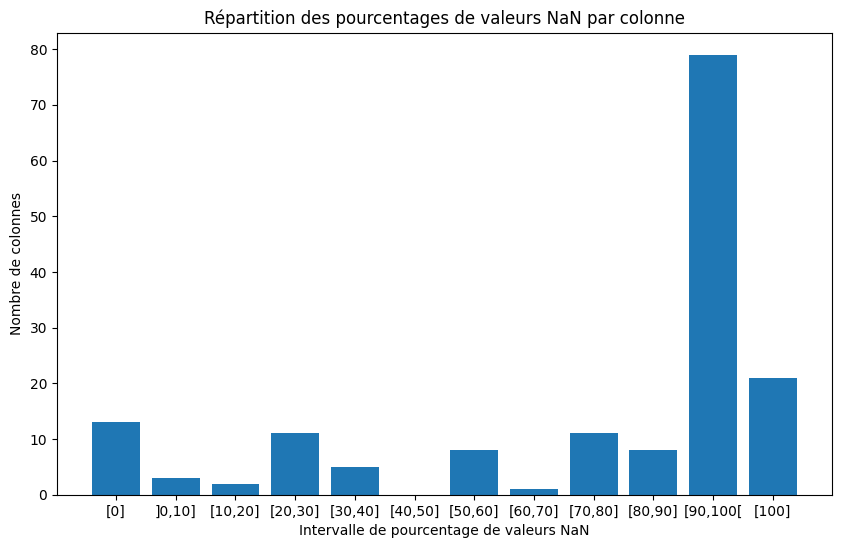

In [31]:
plot_nan_pourcentages(DataProduits)

**On va supprimer en 1er lieu les colonnes ayant 100% de NaN**

In [32]:
# Obtenir les noms de colonnes avant la suppression
cols_before = DataProduits.columns

# Supprimer les colonnes avec 100% de valeurs manquantes
DataProduits = DataProduits.dropna(axis=1, how='all')

# Obtenir les noms de colonnes après la suppression
cols_after = DataProduits.columns

# Comparer les noms de colonnes avant et après la suppression
deleted_cols = set(cols_before) - set(cols_after)

# Afficher les noms des colonnes supprimées
print("Les colonnes suivantes ont été supprimées: ", list(deleted_cols))

Les colonnes suivantes ont été supprimées:  ['erucic-acid_100g', 'behenic-acid_100g', 'elaidic-acid_100g', 'dihomo-gamma-linolenic-acid_100g', 'gondoic-acid_100g', 'cities', 'cerotic-acid_100g', 'lignoceric-acid_100g', 'melissic-acid_100g', 'nervonic-acid_100g', 'nutrition_grade_uk', 'mead-acid_100g', 'ingredients_that_may_be_from_palm_oil', 'water-hardness_100g', 'glycemic-index_100g', 'no_nutriments', 'butyric-acid_100g', 'allergens_fr', 'caproic-acid_100g', 'chlorophyl_100g', 'ingredients_from_palm_oil']


Il faut faire attention, on a supprimé des colonnes qui ont des équivalents "_tags", plus tard on souhaite supprimer ces dernières, mais on ne le fera pas si "_tags" n'a plus son équivalent classique, on va garder ces exceptions dans une liste

In [33]:
new_cols = []
for col in deleted_cols:
    col_tags = col + "_tags"
    if col_tags in DataProduits.columns:
        new_cols.append(col_tags)

print(new_cols)

['cities_tags', 'ingredients_that_may_be_from_palm_oil_tags', 'ingredients_from_palm_oil_tags']


**En général, pour avoir un dataset précis et que les interpolations se fassent avec précision, les colonnes ne doivent pas dépasser 50% de NaN (pour les colonnes quantitatives**

In [34]:
result = supprimer_colonnes_quantitatives_nan_sup_50p(DataProduits)
print("Colonnes quantitatives ayant plus de 50% de NaN:", result)

Colonnes quantitatives ayant plus de 50% de NaN: ['energy-from-fat_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'montanic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g', 'omega-6-fat_100g', 'linoleic-acid_100g', 'arachidonic-acid_100g', 'gamma-linolenic-acid_100g', 'omega-9-fat_100g', 'oleic-acid_100g', 'trans-fat_100g', 'cholesterol_100g', 'sucrose_100g', 'glucose_100g', 'fructose_100g', 'lactose_100g', 'maltose_100g', 'maltodextrins_100g', 'starch_100g', 'polyols_100g', 'casein_100g', 'serum-proteins_100g', 'nucleotides_100g', 'alcohol_100g', 'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'f

On va supprimer ces colonnes quantitatives

In [35]:
columns_to_drop = [col for col in DataProduits.columns if col in result]
DataProduits = DataProduits.drop(columns=columns_to_drop)

In [36]:
# suppression des colonnes en utilisant la liste d'indices
rows, columns = DataProduits.shape
print("Nombre de lignes: ", rows)
print("Nombre de colonnes: ", columns)

Nombre de lignes:  320749
Nombre de colonnes:  68


# Supression des lignes NaN

On va supprimer les lignes qui ne possèdent que des 0 ou des NaN dans leurs colonnes quantitatives (type = float)

In [37]:
DataProduits = supprimer_lignes_nan(DataProduits)

56113 lignes ont été supprimées.


# Filtrage des colonnes

## Suppression colonnes non "fr"

In [38]:
column_names = DataProduits.columns
print(column_names.tolist())

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_fr', 'main_category', 'main_category_fr', 'image_url', 'image_small_url', 'energy_100

On a des colonnes redondantes, on a une colonne classique avec sa version francaise (_ fr ou fr _).

In [39]:
result = []

results_dict = {}

for nom in column_names:
    if "_fr" in nom:
        base_name = nom.split("_fr")[0]
        if base_name in column_names:
            if base_name not in results_dict:
                results_dict[base_name] = [base_name, nom]
            else:
                results_dict[base_name].append(nom)
            for other_nom in column_names:
                if other_nom.startswith(base_name + "_") and other_nom != nom and "_fr" not in other_nom:
                    if other_nom not in results_dict[base_name]:
                        results_dict[base_name].insert(-1, other_nom)

for nom in column_names:
    match = re.search(r"^(.+)(?<![a-z])fr(?![a-z])(.+)$", nom)
    if match:
        base_name = match.group(1)
        suffix = match.group(2)
        found_pair = False
        for other_nom in column_names:
            if other_nom.startswith(base_name) and other_nom.endswith(suffix) and other_nom != nom and not re.search(r"(?<![a-z])fr(?![a-z])", other_nom):
                t = (base_name, nom, other_nom)
                if (base_name, nom) in results_dict:
                    del results_dict[(base_name, nom)]
                results_dict[t] = t
                found_pair = True
                break
        if not found_pair:
            t = (base_name, nom)
            results_dict[t] = t

result = list(results_dict.values())
result = [tuple(y for y in x if y in column_names) for x in result]
result = [x for x in result if x]
print(result)


[('categories', 'categories_tags', 'categories_fr'), ('labels', 'labels_tags', 'labels_fr'), ('countries', 'countries_tags', 'countries_fr'), ('traces', 'traces_tags', 'traces_fr'), ('additives', 'additives_n', 'additives_tags', 'additives_fr'), ('states', 'states_tags', 'states_fr'), ('main_category', 'main_category_fr'), ('nutrition-score-fr_100g', 'nutrition-score-uk_100g')]


In [40]:
filtered_result = [item for t in result for item in t if "_fr" not in item and "fr_" not in item]
print(filtered_result)

['categories', 'categories_tags', 'labels', 'labels_tags', 'countries', 'countries_tags', 'traces', 'traces_tags', 'additives', 'additives_n', 'additives_tags', 'states', 'states_tags', 'main_category', 'nutrition-score-uk_100g']


In [41]:
columns_to_drop = [col for col in DataProduits.columns if col in filtered_result]
DataProduits = DataProduits.drop(columns=columns_to_drop)

In [42]:
rows, columns = DataProduits.shape
print("Nombre de lignes: ", rows)
print("Nombre de colonnes: ", columns)

Nombre de lignes:  264636
Nombre de colonnes:  53


# Netoyage manuel

## Temps

On a une version classique "_datetime" (Ex: 2015-06-16T15:57:13Z) et une version illisible pour le grand public "_t" (Ex: 1434470233)  
On va supprimer les colonnes possédant ce "_t"

In [43]:
# Sélectionnez les colonnes à supprimer
cols_to_drop = [col for col in DataProduits.columns if col.endswith('_t')]
DataProduits = DataProduits.drop(cols_to_drop, axis=1)

# Afficher le nom des colonnes supprimées
print("Les colonnes suivantes ont été supprimées : ", cols_to_drop)

Les colonnes suivantes ont été supprimées :  ['created_t', 'last_modified_t']


## Tags

On a une version classique (Ex: brands -> Auchan,L'oiseau) et une version "_tags" (Ex: brands_tags -> auchan,l-oiseau)  
Le formatage tags est moins élégant, on va le supprimer

In [44]:
# Sélectionnez les colonnes à supprimer
cols_to_drop = [col for col in DataProduits.columns if col.endswith('_tags') and col not in new_cols]
DataProduits = DataProduits.drop(cols_to_drop, axis=1)

# Afficher le nom des colonnes supprimées
print("Les colonnes suivantes ont été supprimées : ", cols_to_drop)

Les colonnes suivantes ont été supprimées :  ['packaging_tags', 'brands_tags', 'origins_tags', 'manufacturing_places_tags', 'emb_codes_tags']


## Noms des produits

On a "product_name" (Exemple -> Hachis Parmentier, Surgelé) qui possède un meilleur formatage et possède plus de précisions que generic_name (Hachis parmentier)  
On va par conséquent supprimer "generic_name"

In [45]:
DataProduits = DataProduits.drop("generic_name", axis=1)

## states_fr

Cette colonne a l'air de ne posséder que des valeurs possédant "A vérifier" ou "A completer"

In [46]:
df = DataProduits

# Sélectionner les valeurs de la colonne "states_fr" qui ne contiennent pas "A vérifier" ou "A compléter"
not_to_check = df.loc[~(df["states_fr"].str.contains("A vérifier") | df["states_fr"].str.contains("A compléter"))]

# Enlever les lignes contenant des NaN
not_to_check = not_to_check.dropna(subset=["states_fr"])

# Afficher les valeurs sélectionnées
not_to_check

,code,url,creator,created_datetime,last_modified_datetime,product_name,quantity,packaging,brands,categories_fr,origins,manufacturing_places,labels_fr,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries_fr,ingredients_text,allergens,traces_fr,serving_size,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,image_url,image_small_url,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g


Ce n'est pas très intéréssant -> On va la supprimer 

In [47]:
DataProduits = DataProduits.drop("states_fr", axis=1)

## Redondance emb_codes VS first_packaging_code_geo?

In [48]:
result = DataProduits.loc[DataProduits['code'] == 3248830085058, 'emb_codes'].iloc[0]
print("code = 3248830085058")
print("emb_codes = " + result)

code = 3248830085058
emb_codes = FR 86.160.002 EC


"emb_codes" fait référence aux codes d'embouteillage, qui sont des identifiants uniques attribués aux établissements impliqués dans la production et l'emballage des denrées alimentaires. Ces codes sont utilisés pour assurer la traçabilité des produits et faciliter le suivi en cas de problème de qualité ou de sécurité alimentaire.  

Ici, "86.160" fait référence au département de la Vienne en France.

Malheureusement, ce code n'indique pas la ville dans lequel la production et l'emballage fut effectué, contrairement à la colonne cities_tags qui indique la ville Mirebeau (Vienne)

Il est donc pas pertinant de supprimer l'une de ces 2 colonnes, car chacu'une d'entre elles possèdent des informations complémentaires

## pnns_groups_1 et	pnns_groups_2

In [49]:
pnns_groups_1 = DataProduits.loc[DataProduits['code'] == 3248830085058, 'pnns_groups_1'].iloc[0]
main_category_fr = DataProduits.loc[DataProduits['code'] == 3248830085058, 'main_category_fr'].iloc[0]
pnns_groups_2 = DataProduits.loc[DataProduits['code'] == 3248830085058, 'pnns_groups_2'].iloc[0]
categories_fr	 = DataProduits.loc[DataProduits['code'] == 3248830085058, 'categories_fr'].iloc[0]
print("code = 3248830085058")
print("pnns_groups_1 = " + pnns_groups_1)
print("main_category_fr = " + main_category_fr)
print("")
print("pnns_groups_2 = " + pnns_groups_2)
print("categories_fr = " + categories_fr)

code = 3248830085058
pnns_groups_1 = Composite foods
main_category_fr = Plats préparés

pnns_groups_2 = Pizza pies and quiche
categories_fr = Plats préparés,Pizzas tartes salées et quiches,Quiches,Quiches lorraines


pnns_groups_1 et pnns_groups_2 ont leurs équivalents francais (main_category_fr, categories_fr)  
On supprime par conséquent la pair (pnns_groups_1 pnns_groups_2) par cause de redondance

In [50]:
DataProduits = DataProduits.drop("pnns_groups_1", axis=1)
DataProduits = DataProduits.drop("pnns_groups_2", axis=1)

De plus, **categories_fr** possède les informations de **main_category_fr** -> On supprime **main_category_fr**

In [51]:
DataProduits = DataProduits.drop("main_category_fr", axis=1)

## Colonnes finissant par "_ n"

In [52]:
df = DataProduits
# Récupérer toutes les colonnes finissant par "_n"
cols = [col for col in df.columns if col.endswith("_n")]

# Couper le mot de ces colonnes pour ne récupérer que la partie sans "_n"
new_cols = [col.rstrip("_n") for col in cols]

# Rechercher toutes les colonnes qui ont dans leur nom la partie coupée
result_cols = [col for col in df.columns if any(new_col in col for new_col in new_cols)]

row = df.loc[df["code"] == 3248830085058]

# Afficher les valeurs des colonnes dans result_cols
row[result_cols]

,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags
204705,1.0,huile-de-palme,1.0,e471-mono-et-diglycerides-d-acides-gras-alimen...


On remarque qu'avoir des colonnes avec _n est redondant, on a plus de précision avec leurs équivalents _tags, on va par conséquent supprimer ces colonnes

In [53]:
# Supprimer les colonnes
DataProduits = DataProduits.drop(columns=cols, axis=1)
print("Les colonnes suivantes ont être supprimées :", cols)

Les colonnes suivantes ont être supprimées : ['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n']


## Comparaison valeurs fat_100g et saturated-fat_100g

Comme on a graisse saturée + graise insaturée = graisse totale   
Alors value(saturated_fat_100g) <= value(fat_100g)   
On va vérifier ca et supprimer les 2 valeurs si une ligne respecte pas cette condition

In [54]:
counter = 0

# Parcourez chaque ligne du dataframe
for i, row in DataProduits.iterrows():
    # Vérifiez si la condition est remplie pour la ligne actuelle
    if row['saturated-fat_100g'] > row['fat_100g']:
        # Si la condition n'est pas remplie, augmentez le compteur
        counter += 1
        # Rendez les valeurs fat et saturated-fat en NaN
        DataProduits.at[i, 'fat_100g'] = float('NaN')
        DataProduits.at[i, 'saturated-fat_100g'] = float('NaN')

# Affichez le nombre de lignes qui ne respectent pas l'inégalité
print(f"Nombre de lignes qui ne respectent pas l'inégalité: {counter}")
print("Ces valeurs de fat_100g et de saturated-fat_100g ont été supprimés en conséquence.")

Nombre de lignes qui ne respectent pas l'inégalité: 354
Ces valeurs de fat_100g et de saturated-fat_100g ont été supprimés en conséquence.


# Recherche des outliers

## Supression des valeurs impossibles

Les colonnes finissant par _100g doivent toutes posséder des valeurs comprises entre 0 et 100.  

On a 2 exceptions cependant:  

1) La colonne **energy_100g** qui mesure le nombre de calories pour 100g de produit (on ne considérera que les valeurs positives)
2) La colonne **nutrition-score-fr_100g** qui donne une valeur numérique du nutriscore  
> A : -15 à -1  
B : 0 à 2  
C : 3 à 10  
D : 11 à 18  
E : 19 à 40  



On vérifie d'abord si les scores numériques "nutrition-score-fr_100g" sont en concordance avec les scores en lettres "nutrition_grade_fr"  
Si c'est pas le cas, on supprime les 2 scores dans la ligne

In [55]:
import pandas as pd
import numpy as np

# Fonction pour vérifier si les valeurs correspondent
def verification_nutriscore(df):
    modified_rows = []

    def verify(row):
        nonlocal modified_rows
        
        score = row['nutrition-score-fr_100g']
        grade = row['nutrition_grade_fr']
        
        if pd.isna(score) or pd.isna(grade):
            return row
        else:
            if ((-15 <= score <= -1) and grade == 'a') or \
               ((0 <= score <= 2) and grade == 'b') or \
               ((3 <= score <= 10) and grade == 'c') or \
               ((11 <= score <= 18) and grade == 'd') or \
               ((19 <= score <= 40) and grade == 'e'):
                return row
            else:
                modified_rows.append((row.name, score, grade))
                row['nutrition-score-fr_100g'] = np.nan
                row['nutrition_grade_fr'] = np.nan
                return row

    df = df.apply(verify, axis=1)
    
    count = len(modified_rows)
    print(f"{count} lignes ont été modifiées.")
    if modified_rows:
        example = modified_rows[0]
        print(f"Exemple de ligne modifiée : index {example[0]}, nutrition-score-fr_100g = {example[1]}, nutrition_grade_fr = {example[2]}")
    
    return df


In [56]:
DataProduits = verification_nutriscore(DataProduits)

3272 lignes ont été modifiées.
Exemple de ligne modifiée : index 226, nutrition-score-fr_100g = 13.0, nutrition_grade_fr = e


On vérifie ensuite les valeurs impossibles

In [57]:
# 1) Récupérer toutes les colonnes finissant par _100g (sauf energy_100g)
cols_100g = [col for col in DataProduits.columns if col.endswith('_100g')]

# Initialisez un dictionnaire pour stocker les informations
results = {'Colonne': [], 'Nombre': [], 'Valeur Aléatoire': []}

# 2) Donner pour chacune des colonnes le nombre de lignes dont les valeurs ne sont pas comprises dans la fourchette [0, 100] et sélectionner une valeur au hasard respectant les conditions
for col in cols_100g:
    if col == "energy_100g":
        filtered_data = DataProduits[(DataProduits[col] < 0)]
    elif col == "nutrition-score-fr_100g":
        filtered_data = DataProduits[(DataProduits[col] < -15) | (DataProduits[col] > 40)]
    else:
        filtered_data = DataProduits[(DataProduits[col] < 0) | (DataProduits[col] > 100)]

    count = len(filtered_data)
    random_value = filtered_data.sample(1)[col].iloc[0] if not filtered_data.empty else None

    # Ajoutez les informations collectées au dictionnaire
    results['Colonne'].append(col)
    results['Nombre'].append(count)
    results['Valeur Aléatoire'].append(random_value)

# Convertir le dictionnaire en dataframe
df = pd.DataFrame(results)

# Définir la colonne "colonne" comme index
df.set_index('Colonne', inplace=True)

# Enlever le nom de l'index
df.index.name = None

# Afficher le dataframe
df


,Nombre,Valeur Aléatoire
energy_100g,0,NaN
fat_100g,4,380.000
saturated-fat_100g,3,550.000
carbohydrates_100g,19,105.000
sugars_100g,19,-0.800
fiber_100g,5,250.000
proteins_100g,4,-800.000
salt_100g,158,187.960
sodium_100g,34,708.333
nutrition-score-fr_100g,0,NaN


In [58]:
for col in cols_100g:
    if col == "energy_100g":
        DataProduits[col] = DataProduits[col].apply(lambda x: np.nan if x < 0 else x)
    elif col == "nutrition-score-fr_100g":
        DataProduits[col] = DataProduits[col].apply(lambda x: np.nan if x < -15 or x > 40 else x)
    else:
        DataProduits[col] = DataProduits[col].apply(lambda x: np.nan if x < 0 or x > 100 else x)
        
print("Ces valeurs impossibles ont été supprimés")

Ces valeurs impossibles ont été supprimés


## Méthode des écarts interquartiles (IQR)

In [59]:
df_results = detecter_et_analyser_outliers_iqr(DataProduits)
format_number(df_results)

,Nombre d'outliers,Pourcentage,Minimum
energy_100g,1088,0.41,3603
fat_100g,8238,3.11,51.03
saturated-fat_100g,17135,6.47,17.86
carbohydrates_100g,0,0,nan
sugars_100g,15207,5.75,58.18
fiber_100g,14123,5.34,9.09
proteins_100g,12626,4.77,23.86
salt_100g,16119,6.09,3.37
sodium_100g,16228,6.13,1.33
nutrition-score-fr_100g,4,0.0015,40


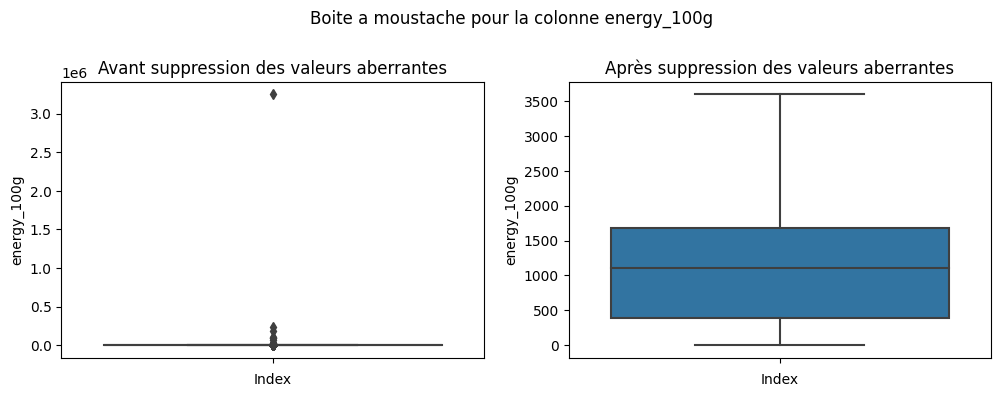

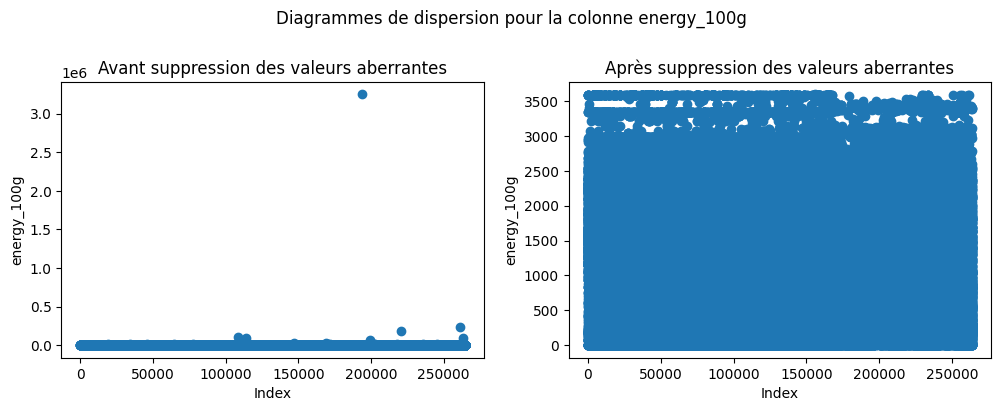

,Avant supression outliers,Après supression outliers
Nombre,2.589380e+05,257850.000000
Moyenne,1.151506e+03,1123.675948
Médiane,1.113000e+03,1105.000000
Écart type,6.473322e+03,778.204656
Minimum,0.000000e+00,0.000000
Maximum,3.251373e+06,3598.000000


In [60]:
colonne = "energy_100g"
# Utilisez la colonne 'salt_100g' de votre DataFrame
df = DataProduits[[colonne]]

# Calculez le Q1, Q3 et l'intervalle interquartile (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identifiez les valeurs aberrantes
outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

# Supprimez les valeurs aberrantes
df_no_outliers = df[~outliers.any(axis=1)]

# Affichez les boxplot avant et après la suppression des valeurs aberrantes
plt.figure(figsize=(12, 4))
plt.suptitle(f"Boite a moustache pour la colonne {colonne}")

plt.subplot(1, 2, 1)
sns.boxplot(data=df)
plt.title("Avant suppression des valeurs aberrantes")
plt.xlabel("Index")
plt.ylabel(colonne)
plt.xticks([0], [""])  # Personnalisez l'axe des abscisses avec uniquement "Index"

plt.subplot(1, 2, 2)
sns.boxplot(data=df_no_outliers)
plt.title("Après suppression des valeurs aberrantes")
plt.xlabel("Index")
plt.ylabel(colonne)
plt.xticks([0], [""])  # Personnalisez l'axe des abscisses avec uniquement "Index"

plt.subplots_adjust(top=0.8)
plt.show()

# Affichez les diagrammes de dispersion avant et après la suppression des valeurs aberrantes
plt.figure(figsize=(12, 4))
plt.suptitle(f"Diagrammes de dispersion pour la colonne {colonne}")

plt.subplot(1, 2, 1)
plt.scatter(range(len(df)), df[colonne])
plt.title("Avant suppression des valeurs aberrantes")
plt.xlabel("Index")
plt.ylabel(colonne)

plt.subplot(1, 2, 2)
plt.scatter(range(len(df_no_outliers)), df_no_outliers[colonne])
plt.title("Après suppression des valeurs aberrantes")
plt.xlabel("Index")
plt.ylabel(colonne)

plt.subplots_adjust(top=0.8)

plt.show()

# Calculer la médiane
median_df = df.median()
median_df_no_outliers = df_no_outliers.median()

# Ajouter la médiane aux sorties de df.describe() et df_no_outliers.describe()
median_df = pd.Series(median_df, name='median').to_frame().T
median_df_no_outliers = pd.Series(median_df_no_outliers, name='median').to_frame().T

describe_df = pd.concat([df.describe(), median_df])
describe_df_no_outliers = pd.concat([df_no_outliers.describe(), median_df_no_outliers])

# Concaténation des sorties de describe_df et describe_df_no_outliers
result = pd.concat([describe_df, describe_df_no_outliers], axis=1)

# Renommer les colonnes pour différencier les sorties
result.columns = ['Avant supression outliers', 'Après supression outliers']

# Supprimer les lignes '25%', '50%' et '75%'
result = result.drop(['25%', '50%', '75%'])

# Renommer les index
result = result.rename(index={'count': 'Nombre',
                               'mean': 'Moyenne',
                               'std': 'Écart type',
                               'min': 'Minimum',
                               'max': 'Maximum',
                               'median': 'Médiane'})

# Réordonner les lignes pour afficher 'Médiane' après 'Moyenne'
result = result.reindex(['Nombre', 'Moyenne', 'Médiane', 'Écart type', 'Minimum', 'Maximum'])

result


On va supprimer les outliers de energy_100g (car il ne possède pas techniquement de limites hautes)

In [61]:
def remove_outliers_iqr(df, column, k=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[column] < (Q1 - k * IQR)) | (df[column] > (Q3 + k * IQR))
    df = df[~mask]
    return df

In [62]:
DataProduits = remove_outliers_iqr(DataProduits, "energy_100g")

# Corrélation entre les colonnes quantitatives (Heatmap)

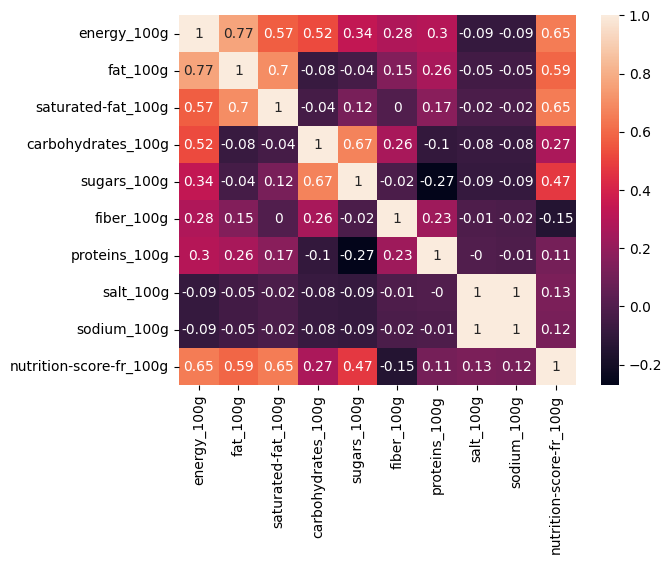

Les colonnes fortement corrélées entre elles sont :
(sodium_100g, salt_100g)


In [63]:
colonnes_corelees = heatmap_correlation_colonnes(DataProduits)

Comme salt_100g est plus simple à comprendre que sodium_100g, on va supprimer la colonne sodium_100g

In [64]:
DataProduits.drop("sodium_100g", axis=1, inplace=True)

# Remplissage des NaN

## Test de plusieurs techniques d'imputation

Nous allons récupérer un échantillon du dataframe pour commencer nos tests

L'échantillon est suffisamment représentatif de l'ensemble de données après 3 tentatives.


,Variable,Diff_Moyenne_Relative,Diff_Mediane_Relative,Diff_EcartType_Relative,Diff_Skewness_Relative,Diff_Kurtosis_Relative
0,energy_100g,0.229077,0.452489,0.117555,2.317732,2.010687
1,fat_100g,0.377062,1.960784,0.018325,1.053356,2.257240
2,saturated-fat_100g,0.205084,0.000000,0.126907,0.600665,2.174464
3,carbohydrates_100g,0.187941,0.000000,0.024738,0.758807,0.352245
4,sugars_100g,0.148250,0.340136,0.098314,0.300121,1.121437
5,fiber_100g,0.553627,0.000000,0.888183,1.798109,4.977920
6,proteins_100g,0.348705,1.224490,0.314616,0.647254,0.919251
7,salt_100g,0.735882,0.516667,2.176581,0.731743,2.102477
8,nutrition-score-fr_100g,0.178387,0.000000,0.148129,0.494771,0.032863


L'échantillon est suffisamment représentatif de l'ensemble de données après 3 tentatives.


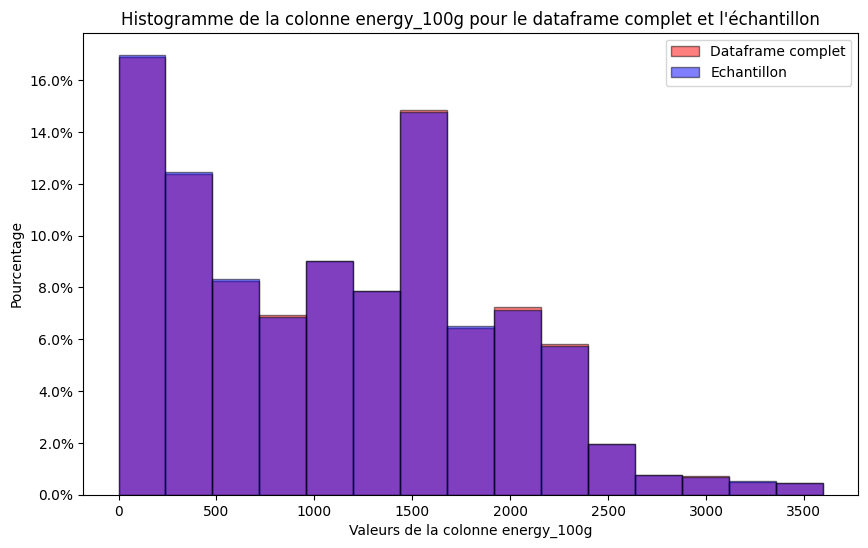

In [65]:
sample = trouver_le_bon_sample(DataProduits, proportion=30, threshold=5, tentatives = 50)

A partir de ce sample on va créer un sample_non_nan (sample imputé de ses nan) et un sample_nan (sample_non_nan auquel on rajoute des nan)

In [66]:
sample_nan, sample_non_nan = creation_samples_simulations(DataProduits, sample)

,DataFrame,sample_nan
energy_100g,2.162035,2.062510
fat_100g,8.748691,8.907427
saturated-fat_100g,13.649506,13.488006
carbohydrates_100g,8.717577,8.778641
sugars_100g,7.803512,7.690681
fiber_100g,24.183071,24.025450
proteins_100g,2.615842,2.546901
salt_100g,4.312307,4.230740
nutrition-score-fr_100g,17.799414,17.791788


On teste après plusieurs techniques d'imputations

In [67]:
imputer_KNN, evaluation_metrics_KNN = evaluation_imputation(sample_nan, sample_non_nan, imputer = "KNNImputer")

Temps écoulé FIT: 0.00 secondes
Temps écoulé IMPUTATION: 86.87 secondes


,Column,R²,RMSE,MAE
0,energy_100g,0.996542,43.729795,3.657372
1,fat_100g,0.981959,2.049902,0.325902
2,saturated-fat_100g,0.966093,1.236259,0.239339
3,carbohydrates_100g,0.979570,4.024944,0.717839
4,sugars_100g,0.981798,2.630578,0.414854
5,fiber_100g,0.882922,1.486229,0.339627
6,proteins_100g,0.990900,0.751651,0.069743
7,salt_100g,0.967633,0.655123,0.032402
8,nutrition-score-fr_100g,0.965433,1.692281,0.501595


In [68]:
imputer_Iterative, evaluation_metrics_Iterative = evaluation_imputation(sample_nan, sample_non_nan, imputer = "IterativeImputer")

Temps écoulé FIT: 6.34 secondes
Temps écoulé IMPUTATION: 0.75 secondes


,Column,R²,RMSE,MAE
0,energy_100g,0.998495,28.847515,1.956992
1,fat_100g,0.994137,1.168542,0.169817
2,saturated-fat_100g,0.945855,1.562235,0.380012
3,carbohydrates_100g,0.991268,2.631441,0.390832
4,sugars_100g,0.967593,3.510012,0.710849
5,fiber_100g,0.834400,1.767576,0.500375
6,proteins_100g,0.989765,0.797169,0.087262
7,salt_100g,0.950941,0.806549,0.049837
8,nutrition-score-fr_100g,0.951036,2.014097,0.645734


In [69]:
imputer_Simple, evaluation_metrics_Simple = evaluation_imputation(sample_nan, sample_non_nan, imputer = "SimpleImputer")

Temps écoulé FIT: 0.01 secondes
Temps écoulé IMPUTATION: 0.01 secondes


,Column,R²,RMSE,MAE
0,energy_100g,0.978994,107.777669,13.426027
1,fat_100g,0.911760,4.533453,1.052287
2,saturated-fat_100g,0.867441,2.444390,0.663787
3,carbohydrates_100g,0.912766,8.317157,2.221676
4,sugars_100g,0.923911,5.378357,1.175039
5,fiber_100g,0.766033,2.100999,0.653941
6,proteins_100g,0.976352,1.211718,0.145089
7,salt_100g,0.945394,0.850923,0.050718
8,nutrition-score-fr_100g,0.822914,3.830316,1.399274


On compare ces 3 imputations:

In [70]:
comparison_df, winner = imputation_winner(evaluation_metrics_Iterative, evaluation_metrics_KNN, evaluation_metrics_Simple)

Le gagnant est KNN avec 18 apparitions sur 27 soit 66.67% d'apparitions.


,Column,R² Winner,RMSE Winner,MAE Winner
0,energy_100g,Iterative,Iterative,Iterative
1,fat_100g,Iterative,Iterative,Iterative
2,saturated-fat_100g,KNN,KNN,KNN
3,carbohydrates_100g,Iterative,Iterative,Iterative
4,sugars_100g,KNN,KNN,KNN
5,fiber_100g,KNN,KNN,KNN
6,proteins_100g,KNN,KNN,KNN
7,salt_100g,KNN,KNN,KNN
8,nutrition-score-fr_100g,KNN,KNN,KNN


**Nous allons désormais imputer le DataFrame avec cette méthode**

On conditionne en 1er lieu les valeurs supérieures ou égales à -15 (à cause de la colonne nutrition-score-fr_100g)

In [71]:
DataProduits_imputed_KNN = KNNImputer_(DataProduits, seuil_min=-15, seuil_max=None, n_neighbors=5)

# Reformatage des valeurs de nutrition-score-fr_100g

L'utilisation de l'imputation KNN a entraîné la création de valeurs non entières dans cette colonne, ce qui n'est pas supposé etre possible, il va falloir reconvertir ces valeurs pour etre sur de n'avoir que des entiers.

In [77]:
DataProduits_imputed_KNN['nutrition-score-fr_100g'] = np.round(DataProduits_imputed_KNN['nutrition-score-fr_100g'])

In [78]:
DataProduits_imputed_KNN.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
count,263548.000000,263548.000000,263548.000000,263548.000000,263548.000000,263548.000000,263548.000000,263548.000000,263548.000000
mean,1123.791353,12.289777,4.565935,32.181937,15.582478,2.559703,7.154249,1.595909,8.937450
std,771.358106,16.330693,7.222342,28.207321,20.707481,4.247062,8.075951,6.158141,8.759355
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,397.000000,0.040000,0.000000,6.670000,1.220000,0.000000,0.820000,0.080000,1.000000
50%,1123.675948,5.560000,1.330000,23.010000,5.800000,1.200000,5.000000,0.614680,9.000000
75%,1670.600000,19.350000,6.450000,57.140000,22.580000,3.300000,10.000000,1.440180,15.000000
max,3598.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,40.000000


Désormais, nous pouvons désormais remplir les scores de nutrition_grade_fr à partir des valeurs de nutrition-score-fr_100g

In [83]:
# Fonction pour déterminer la note nutritionnelle en fonction du score

def assign_nutrition_grade(row):
    score = row['nutrition-score-fr_100g']
    grade = row['nutrition_grade_fr']
    
    if pd.isna(grade):
        if -15 <= score <= -1:
            return 'a'
        elif 0 <= score <= 2:
            return 'b'
        elif 3 <= score <= 10:
            return 'c'
        elif 11 <= score <= 18:
            return 'd'
        elif 19 <= score <= 40:
            return 'e'
    else:
        return grade

# Appliquer la fonction sur chaque ligne du DataFrame
DataProduits_imputed_KNN['nutrition_grade_fr'] = DataProduits_imputed_KNN.apply(assign_nutrition_grade, axis=1)



In [84]:
DataProduits_imputed_KNN

,code,url,creator,created_datetime,last_modified_datetime,product_name,quantity,packaging,brands,categories_fr,origins,manufacturing_places,labels_fr,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries_fr,ingredients_text,allergens,traces_fr,serving_size,additives_fr,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,image_url,image_small_url,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09T14:32:37Z,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,28 g (1 ONZ),NaN,NaN,NaN,d,NaN,NaN,2243.0,28.57,28.570,64.290,14.29,3.6,3.57,0.000000,14.0
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09T14:32:37Z,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,Torn & Glasser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,28 g (0.25 cup),NaN,NaN,NaN,b,NaN,NaN,1941.0,17.86,0.000,60.710,17.86,7.1,17.86,0.635000,0.0
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09T10:35:31Z,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,Grizzlies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,28 g (0.25 cup),NaN,NaN,NaN,d,NaN,NaN,2540.0,57.14,5.360,17.860,3.57,7.1,17.86,1.224280,12.0
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09T10:34:13Z,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,Bob's Red Mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,Organic polenta,NaN,NaN,35 g (0.25 cup),NaN,NaN,NaN,a,NaN,NaN,1552.0,1.43,0.120,77.140,4.60,5.7,8.57,0.510000,-2.0
5,16100,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09T10:34:11Z,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,NaN,NaN,Unfi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Rolled oats, grape concentrate, expeller press...",NaN,NaN,52 g (0.5 cup),NaN,NaN,NaN,c,NaN,NaN,1933.0,18.27,1.920,63.460,11.54,7.7,13.46,1.006244,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320751,9847548283004,http://world-fr.openfoodfacts.org/produit/9847...,drmalabar,2015-07-25T09:47:06Z,2015-09-14T13:37:28Z,Tartines craquantes bio au sarrasin,NaN,"Boîte,Carton,Sachet,Plastique",Le Pain des fleurs,"Aliments et boissons à base de végétaux,Alimen...",NaN,France,"Bio,Bio européen,Sans gluten,AB Agriculture Bi...",NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a,http://fr.openfoodfacts.org/images/products/98...,http://fr.openfoodfacts.org/images/products/98...,1643.0,2.80,0.600,74.800,2.60,5.9,13.00,0.680000,-4.0
320756,989898,http://world-fr.openfoodfacts.org/produit/9898...,openfoodfacts-contributors,2016-09-12T15:40:09Z,2016-09-12T15:40:15Z,Test NF App,100gr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Suisse,"Coco, choco",NaN,NaN,NaN,NaN,NaN,NaN,c,NaN,NaN,569.0,31.00,2.708,12.200,9.60,1.1,2.10,1.100000,8.0
320757,9900000000233,http://world-fr.openfoodfacts.org/produit/9900...,kiliweb,2017-04-01T20:52:18Z,2017-04-01T20:52:19Z,Amandes,NaN,NaN,Biosic,NaN,NaN,NaN,"Bio,Bio européen,AB Agriculture Biologique",NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b,NaN,NaN,2406.0,9.88,3.730,17.078,3.89,12.2,21.22,0.100000,0.0
320763,99111250,http://world-fr.openfoodfacts.org/produit/9911...,balooval,2013-04-28T15:30:39Z,2013-06-20T01:09:16Z,Thé vert Earl grey,50 g,"boîte,carton",Lobodis,"Aliments et boissons à base de végétaux,Boisso...",NaN,NaN,"Commerce équitable,Bio,Bio européen,Max Havela...",NaN,NaN,NaN,NaN,NaN,France,"thé vert, arôme naturel bergamote avec autres ...",NaN,NaN,NaN,NaN,NaN,NaN,b,http://fr.openfood

In [85]:
DataProduits_imputed_KNN.to_csv('DataProduits_imputed.csv', index=False)